In [1]:
from tensorflow import keras
import pandas as pd 
import numpy as np
import os
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.cluster import KMeans,DBSCAN
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score,roc_auc_score,fbeta_score
import scipy.stats as ss
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import scipy
import warnings
warnings.filterwarnings("ignore")

In [2]:
###############
# merch lat and merch long have 1 correlation with lat and long, therefore will use lat and long from merchant since is more granular.
# frauds tend to increase drasticly  late at night between 22 and 3  
# The North east part of the Country seems to be the most affected by fraud transactions.
# Older people are the most impacted by farud events.

In [3]:
###################
def date_components(X,dates):
    
    
    for i in dates:
        X[i] = pd.to_datetime(X[i])
        X[i+"_year"] = pd.DatetimeIndex(X[i]).year
        X[i+"_month"] = pd.DatetimeIndex(X[i]).month
        X[i+"_week"] = pd.DatetimeIndex(X[i]).week
        X[i+"_weekday"] = pd.DatetimeIndex(X[i]).day_of_week
        X[i+"_hour"] = pd.DatetimeIndex(X[i]).hour
        X[i+"_date"] = pd.DatetimeIndex(X[i]).date
        X[i+"_day"] = pd.DatetimeIndex(X[i]).day

    return X

###################

def return_plots(data,columns,target_col= 'is_fraud',canvas = [3,4],n_txn = 500, rank_type = "prop" ):

    fig, ax = plt.subplots(canvas[0],canvas[1],figsize = (40,30))

    fraud_avg = data[target_col].mean()
    fraud_std = np.sqrt(data[target_col].mean()*(1- data[target_col].mean()))

    zips  = zip(ax.flat,columns)

    for i,(a,c) in enumerate(zips):

        ax1 = a.twinx()
        
        if re.search("month|week|weekday|hour|day",c):
            
            tt = data.groupby([c]).agg(txn_count = (c,"count"), prop = (target_col,"mean") ).reset_index().sort_values(c).reset_index(drop = True)
            top_10 = tt.copy()
            
        
        else:
            tt = data.groupby([c]).agg(txn_count = (c,"count"), prop = (target_col,"mean") ).reset_index().sort_values(rank_type,ascending = False).reset_index(drop = True)
            top_10 = tt.loc[tt.txn_count>=n_txn][:25]

        labels = top_10[c].tolist()
        x = range(len(labels))
        y = top_10["txn_count"].tolist()
        prop =  top_10["prop"].tolist()

        a.bar(x,y,edgecolor = 'black',label = " {} Prop".format("txn_count"))
        ax1.plot(x,prop,color = 'black',label = "{} Prop".format(target_col))
        ax1.scatter(x,prop,color = 'black')
        a.set_xticks(x)
        a.set_xticklabels(labels,ha='right')
        ax1.hlines(fraud_avg,xmin = x[0], xmax=x[-1], color = 'tab:red',label = "avg {} prop".format(target_col))
        # ax1.hlines(fraud_avg + fraud_std *2,xmin = x[0], xmax=x[-1], color = 'pink',)
        # ax1.hlines(fraud_avg - fraud_std *2,xmin = x[0], xmax=x[-1], color = 'pink')
        # ax1.scatter(x,[fraud_avg]*len(x), color = 'tab:red')
        # ax1.fill_between(
        #     x,
        #     fraud_avg + (fraud_std *2),
        #     fraud_avg - (fraud_std *2),
        #     alpha=0.1,
        # )

        for label in a.get_xticklabels():
            label.set_rotation(45)
        
        
        if i == 0:
            a.legend(bbox_to_anchor = (-0.1,1),frameon =False)
            ax1.legend(bbox_to_anchor = (-0.1,0.87),frameon = False)
        a.set_title(c)
    

In [4]:
## load data set
train = pd.read_csv("fraudTrain.csv")
test = pd.read_csv("fraudTest.csv")



In [5]:
# number of train and test records 
print("train records: {}".format(len(train))+"\n"+"test records: {}".format(len(test)))

train records: 1296675
test records: 555719


In [6]:
# fraud proportions in train file 
print("fraud prop in train: {:.1f}%".format(train.is_fraud.mean() *100) )

fraud prop in train: 0.6%


### Optimization objective: Optimzie Recall: TP/TP+FN

### Data exploration

In [7]:
### cehck attributes
train.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [8]:
### check null values, no null values 
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [9]:
###  unique numbers 
train.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [10]:
### breakdown columns

target = "is_fraud"
cat_cols = [i for i in train.columns if train[i].dtypes == 'object']
num_cols =  [i for i in train.columns if i not in [*cat_cols,target]  ]


In [11]:
### categorical data exploration 
for i in cat_cols:
    print("column {}".format(i))
    print("\n")
    print(train[i].value_counts(normalize = True)[:10])
    print("\n")

column trans_date_trans_time


2019-04-22 16:02:01    0.000003
2020-06-01 01:37:47    0.000003
2020-06-02 12:47:07    0.000003
2019-11-18 23:03:49    0.000002
2019-12-01 14:11:58    0.000002
2019-12-09 17:30:34    0.000002
2019-12-29 21:58:02    0.000002
2020-06-14 07:16:47    0.000002
2019-09-01 19:41:45    0.000002
2019-07-08 18:30:52    0.000002
Name: trans_date_trans_time, dtype: float64


column merchant


fraud_Kilback LLC                   0.003396
fraud_Cormier LLC                   0.002814
fraud_Schumm PLC                    0.002803
fraud_Kuhn LLC                      0.002707
fraud_Boyer PLC                     0.002694
fraud_Dickinson Ltd                 0.002648
fraud_Cummerata-Jones               0.002110
fraud_Kutch LLC                     0.002108
fraud_Olson, Becker and Koch        0.002100
fraud_Stroman, Hudson and Erdman    0.002098
Name: merchant, dtype: float64


column category


gas_transport     0.101536
grocery_pos       0.095350
home              0.094947
sho

In [12]:
cat_cols_plot = cat_cols.copy()
[cat_cols_plot.remove(i) for i in ["trans_date_trans_time","trans_num"]]

train_explore = train.copy()
train_explore = date_components(train_explore,["trans_date_trans_time"])
train_explore = date_components(train_explore,["dob"])
train_explore["len_cc"] = train_explore.cc_num.map(lambda x: len(str(x) ))
train_explore["purchase_type"]  = train_explore.category.map(lambda x: "net" if re.search("net",x) else "pos" if re.search("pos",x) else "other")
train_explore["week_category"] = train_explore.trans_date_trans_time_weekday.map(lambda x: "Weekend" if x in [0,6]  else "start_end_week" if x in [1,5] else "midweek")
train_explore["len_cc_cutoff"] = train_explore.len_cc.map(lambda x: 1 if x <=12 else 0)

In [20]:
tt = train_explore.groupby(["cc_num",'trans_date_trans_time_date'])["amt"].sum().reset_index()
tf = tt.groupby(["cc_num"])["amt"].mean().reset_index()
tf.loc[tf["cc_num"] == 375534208663984]

cc_num         amt
368  375534208663984  372.765456

In [27]:
fraud_dict = train_explore.groupby(["trans_date_trans_time_hour"])["is_fraud"].mean().to_dict()
train_explore["trans_date_trans_time_hour_fd"] = train_explore['trans_date_trans_time_hour'].map(fraud_dict)
train_explore.tail()

Unnamed: 0 trans_date_trans_time               cc_num  \
1296670     1296670   2020-06-21 12:12:08       30263540414123   
1296671     1296671   2020-06-21 12:12:19     6011149206456997   
1296672     1296672   2020-06-21 12:12:32     3514865930894695   
1296673     1296673   2020-06-21 12:13:36     2720012583106919   
1296674     1296674   2020-06-21 12:13:37  4292902571056973207   

                                    merchant       category     amt  \
1296670                    fraud_Reichel Inc  entertainment   15.56   
1296671             fraud_Abernathy and Sons    food_dining   51.70   
1296672                 fraud_Stiedemann Ltd    food_dining  105.93   
1296673  fraud_Reinger, Weissnat and Strosin    food_dining   74.90   
1296674  fraud_Langosh, Wintheiser and Hyatt    food_dining    4.30   

               first       last gender                         street  \
1296670         Erik  Patterson      M       162 Jessica Row Apt. 072   
1296671      Jeffrey      White      M  8617 Holmes Terrace Suite 651   
1296672  Christopher  Castaneda      M     1632 Cohen Drive Suite 639   
1296673       Joseph     Murray      M           42933 Ryan Underpass   
1296674      Jeffrey      Smith      M           135 Joseph Mountains   

                             city state    zip      lat      long  city_pop  \
1296670                     Hatch    UT  84735  37.7175 -112.4777       258   
1296671                 Tuscarora    MD  21790  39.2667  -77.5101       100   
1296672  High Rolls Mountain Park    NM  88325  32.9396 -105.8189       899   
1296673                 Manderson    SD  57756  43.3526 -102.5411      1126   
1296674                      Sula    MT  59871  45.8433 -113.8748       218   

                                      job        dob  \
1296670                      Geoscientist 1961-11-24   
1296671  Production assistant, television 1979-12-11   
1296672                   Naval architect 1967-08-30   
1296673             Volunteer coordinator 1980-08-18   
1296674          Therapist, horticultural 1995-08-16   

                                trans_num   unix_time  merch_lat  merch_long  \
1296670  440b587732da4dc1a6395aba5fb41669  1371816728  36.841266 -111.690765   
1296671  278000d2e0d2277d1de2f890067dcc0a  1371816739  38.906881  -78.246528   
1296672  483f52fe67fabef353d552c1e662974c  1371816752  33.619513 -105.130529   
1296673  d667cdcbadaaed3da3f4020e83591c83  1371816816  42.788940 -103.241160   
1296674  8f7c8e4ab7f25875d753b422917c98c9  1371816817  46.565983 -114.186110   

         is_fraud  trans_date_trans_time_year  trans_date_trans_time_month  \
1296670         0                        2020                            6   
1296671         0                        2020                            6   
1296672         0                        2020                            6   
1296673         0                        2020                            6   
1296674         0                        2020                            6   

         trans_date_trans_time_week  trans_date_trans_time_weekday  \
1296670                          25                              6   
1296671                          25                              6   
1296672                          25                              6   
1296673                          25                              6   
1296674                          25                              6   

         trans_date_trans_time_hour trans_date_trans_time_date  \
1296670                          12                 2020-06-21   
1296671                          12                 2020-06-21   
1296672                          12                 2020-06-21   
1296673                          12                 2020-06-21   
1296674                          12                 2020-06-21   

         trans_date_trans_time_day  dob_year  dob_month  dob_week  \
1296670                         21      1961         11        47   
1296671                     

In [14]:
tt = train_explore.groupby(["cc_num",'trans_date_trans_time_date']).agg(amount = ('amt','sum'), vol = ("cc_num","count")).reset_index()
tt["amt_per_txn"] = tt.apply(lambda x: x["amount"]/x["vol"],axis = 1)
agg = tt.groupby(["cc_num"])["amt_per_txn"].mean().reset_index()
agg

cc_num  amt_per_txn
0            60416207185    53.845449
1            60422928733    66.064329
2            60423098130   140.926290
3            60427851591   100.970997
4            60487002085    49.573266
..                   ...          ...
978  4958589671582726883    66.278734
979  4973530368125489546    75.538500
980  4980323467523543940    66.326980
981  4989847570577635369    85.450071
982  4992346398065154184    66.499554

[983 rows x 2 columns]

In [17]:
agg.loc[agg.cc_num == 375534208663984]

cc_num  amt_per_txn
368  375534208663984    94.427516

In [13]:
train_explore["first_cc_num"] = train_explore.cc_num.map(lambda x: str(x)[:1])

In [14]:
train_explore.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'trans_date_trans_time_year',
       'trans_date_trans_time_month', 'trans_date_trans_time_week',
       'trans_date_trans_time_weekday', 'trans_date_trans_time_hour',
       'trans_date_trans_time_date', 'trans_date_trans_time_day', 'dob_year',
       'dob_month', 'dob_week', 'dob_weekday', 'dob_hour', 'dob_date',
       'dob_day', 'len_cc', 'purchase_type', 'week_category', 'len_cc_cutoff',
       'first_cc_num'],
      dtype='object')

In [15]:
cat_cols_plot.extend(["trans_date_trans_time_hour","trans_date_trans_time_month","trans_date_trans_time_weekday","dob_year","trans_date_trans_time_day"])
cat_cols_plot.append("len_cc")
cat_cols_plot.append("purchase_type")
cat_cols_plot.append("week_category")
cat_cols_plot.append("len_cc_cutoff")
cat_cols_plot.append("first_cc_num")

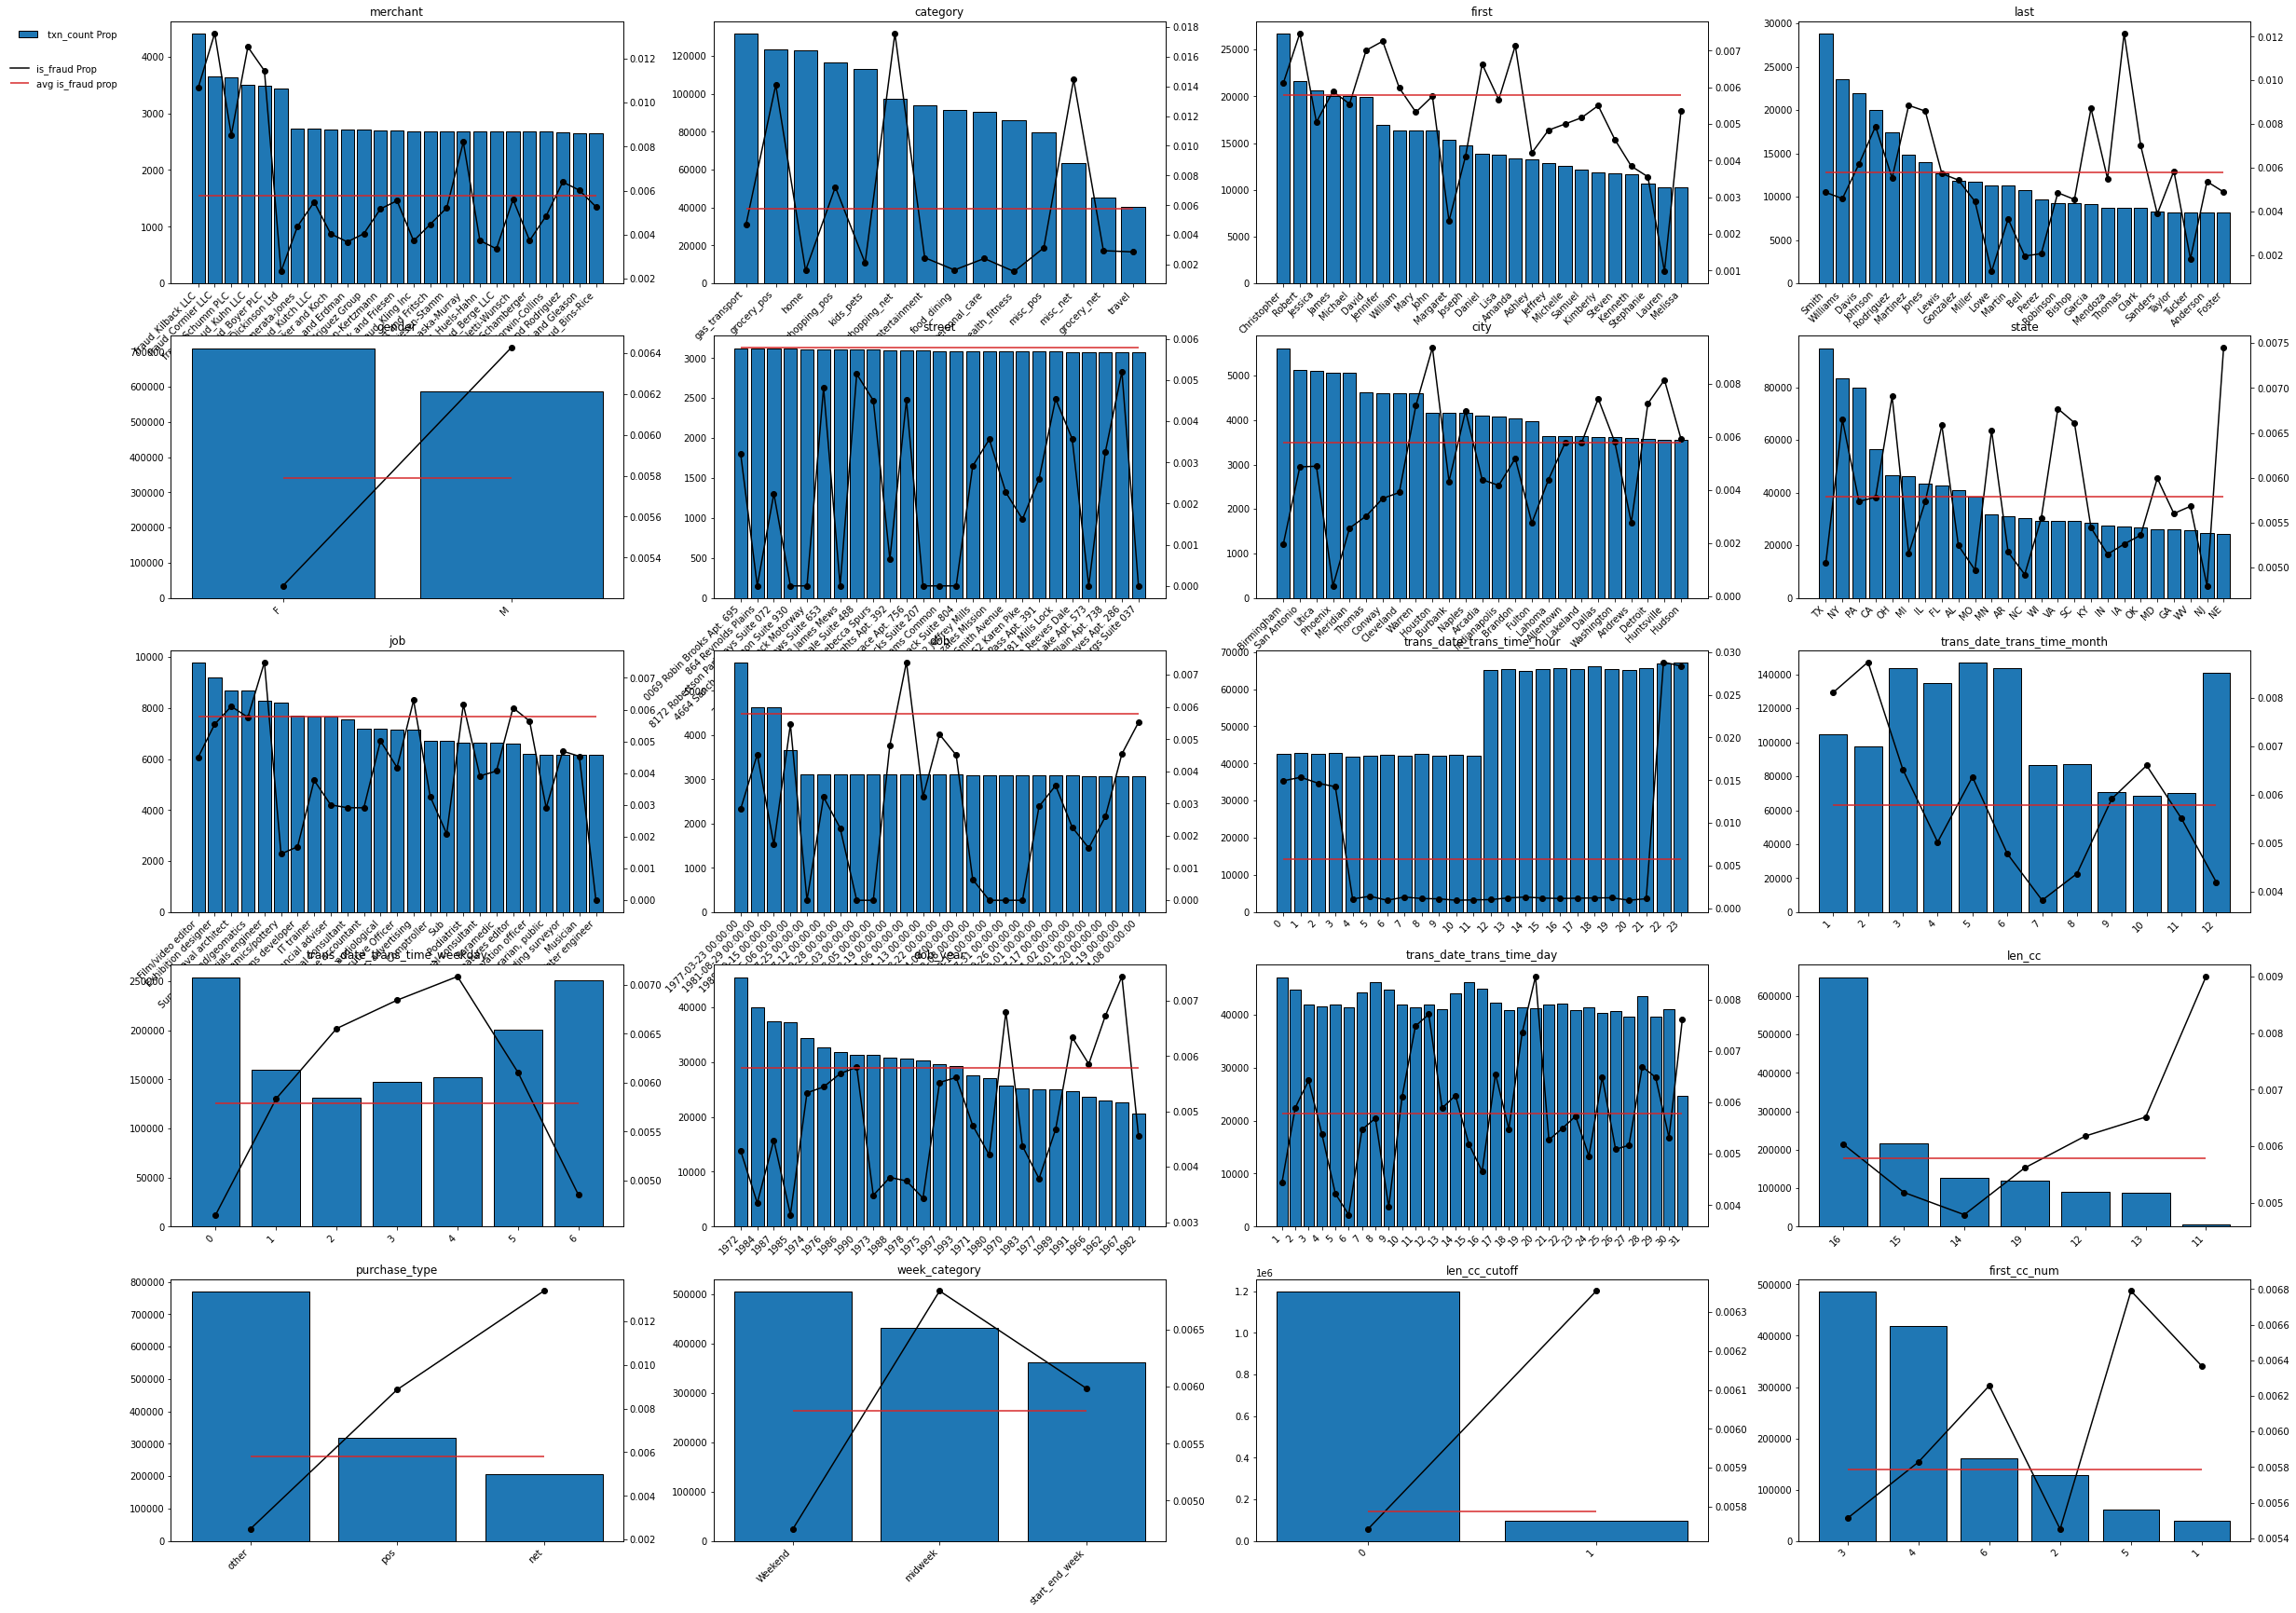

In [16]:
return_plots(train_explore,cat_cols_plot,canvas=[5,4], n_txn=1000, rank_type="txn_count")

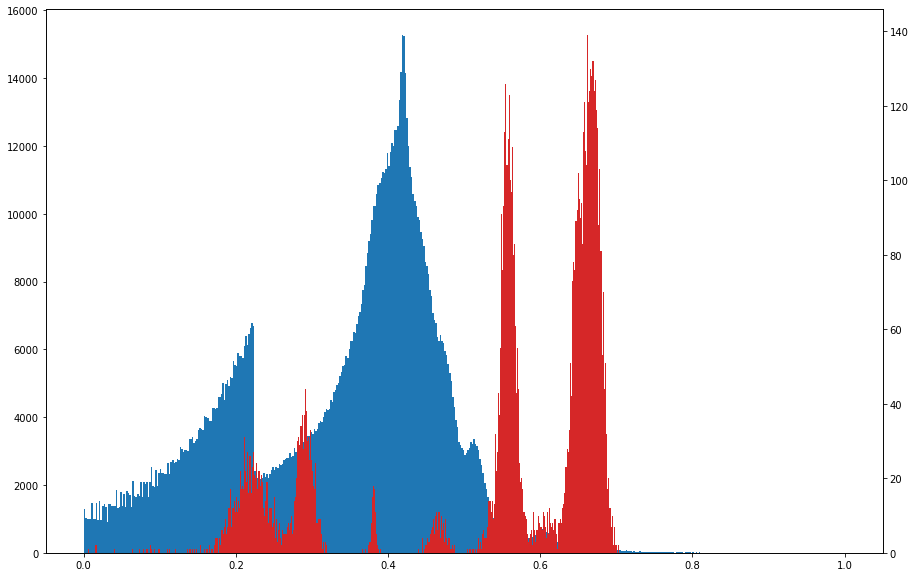

In [17]:
train_explore["log_amt"] = np.log(train_explore.amt)
train_explore["std_log_amt"] = StandardScaler().fit_transform(train_explore[["log_amt"]])
train_explore["norm_log_amt"] = MinMaxScaler().fit_transform(train_explore[["log_amt"]])

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = ax.hist(train_explore[["norm_log_amt"]], bins = 500)
hist = ax1.hist(train_explore.loc[(train_explore.is_fraud==1),["norm_log_amt"]], bins = 500, color = 'tab:red')

#ax[0].scatter(train_explore.loc[train_explore.is_fraud == 1,"lat"], train_explore.loc[train_explore.is_fraud == 1,"long"])

#ax[1].scatter(train_explore.loc[train_explore.is_fraud == 1,"merch_lat"], train_explore.loc[train_explore.is_fraud == 1,"merch_long"])


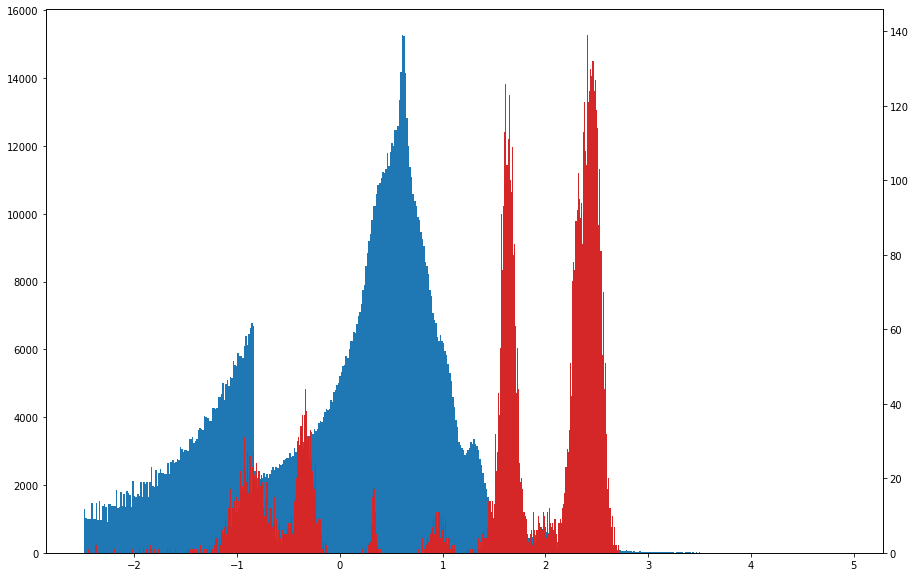

In [18]:
train_explore["log_amt"] = np.log(train_explore.amt)
train_explore["std_log_amt"] = StandardScaler().fit_transform(train_explore[["log_amt"]])
train_explore["norm_log_amt"] = MinMaxScaler().fit_transform(train_explore[["log_amt"]])

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = ax.hist(train_explore[["std_log_amt"]], bins = 500)
hist = ax1.hist(train_explore.loc[(train_explore.is_fraud==1),["std_log_amt"]], bins = 500, color = 'tab:red')

#ax[0].scatter(train_explore.loc[train_explore.is_fraud == 1,"lat"], train_explore.loc[train_explore.is_fraud == 1,"long"])

#ax[1].scatter(train_explore.loc[train_explore.is_fraud == 1,"merch_lat"], train_explore.loc[train_explore.is_fraud == 1,"merch_long"])


In [19]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)

state_geo = f"{url}/us-states.json"

#bins = list(train_explore.loc[train_explore.is_fraud ==1,""].quantile([0, 0.25, 0.5, 0.75, 1]))
state_data = train_explore.loc[:,:].groupby(["state"]).agg(frauds = ("is_fraud","mean"),txn_volume = ("state","count") ).reset_index().query("txn_volume>=4000")

f = folium.Figure(width=1200, height=400)
m = folium.Map(location=[48, -102], zoom_start=3)

f.add_child(m)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["state", "frauds"],
    key_on="feature.id",
    fill_color="BuPu",
    legend_name="fraud proportion",
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

# for i, c in train_explore[["lat","long"]].drop_duplicates().iterrows():
#     folium.Marker(
#     [c["lat"], c["long"]]).add_to(m)


m

In [20]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)

state_geo = f"{url}/us-states.json"

#bins = list(train_explore.loc[train_explore.is_fraud ==1,""].quantile([0, 0.25, 0.5, 0.75, 1]))
state_data = train_explore.loc[train_explore.is_fraud == 1,:].groupby(["state"]).agg(txn_amount = ("amt","mean") ).reset_index() #.query("txn_volume>=4000")

f = folium.Figure(width=1200, height=400)
m = folium.Map(location=[48, -102], zoom_start=3)

f.add_child(m)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["state", "txn_amount"],
    key_on="feature.id",
    fill_color="BuPu",
    legend_name="avg amount fraud",
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

# for i, c in train_explore[["lat","long"]].drop_duplicates().iterrows():
#     folium.Marker(
#     [c["lat"], c["long"]]).add_to(m)


m

In [21]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)

state_geo = f"{url}/us-states.json"

bins = list(train_explore.loc[train_explore.is_fraud ==1,"dob_year"].quantile([0, 0.25, 0.5, 0.75, 1]))
state_data = train_explore.loc[train_explore.is_fraud ==1,:].groupby(["state"])["dob_year"].mean().reset_index()

f = folium.Figure(width=1200, height=400)
m = folium.Map(location=[48, -102], zoom_start=3)

f.add_child(m)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=["state", "dob_year"],
    key_on="feature.id",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="date of birth",
    bins=bins,
    reset=True,
).add_to(m)

m

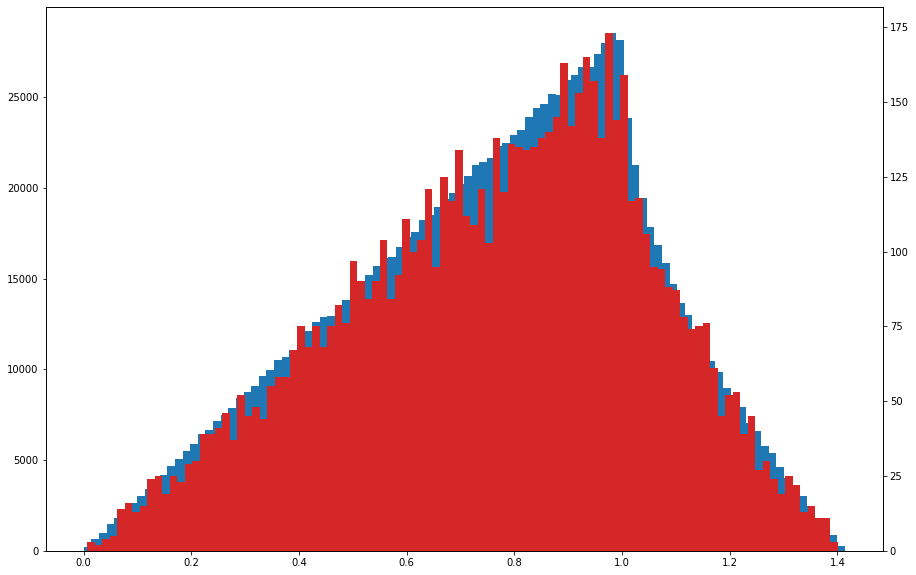

In [22]:
from scipy.spatial.distance import euclidean
train_explore["merchant_customer_distance"] =train_explore.apply(lambda x: euclidean((x["merch_lat"],x["merch_long"]),(x["lat"],x["long"]) ), axis = 1 )


fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = ax.hist(train_explore[["merchant_customer_distance"]], bins = 100)
hist = ax1.hist(train_explore.loc[(train_explore.is_fraud==1),["merchant_customer_distance"]], bins = 100, color = 'tab:red')

#ax[0].scatter(train_explore.loc[train_explore.is_fraud == 1,"lat"], train_explore.loc[train_explore.is_fraud == 1,"long"])

#ax[1].scatter(train_explore.loc[train_explore.is_fraud == 1,"merch_lat"], train_explore.loc[train_explore.is_fraud == 1,"merch_long"])


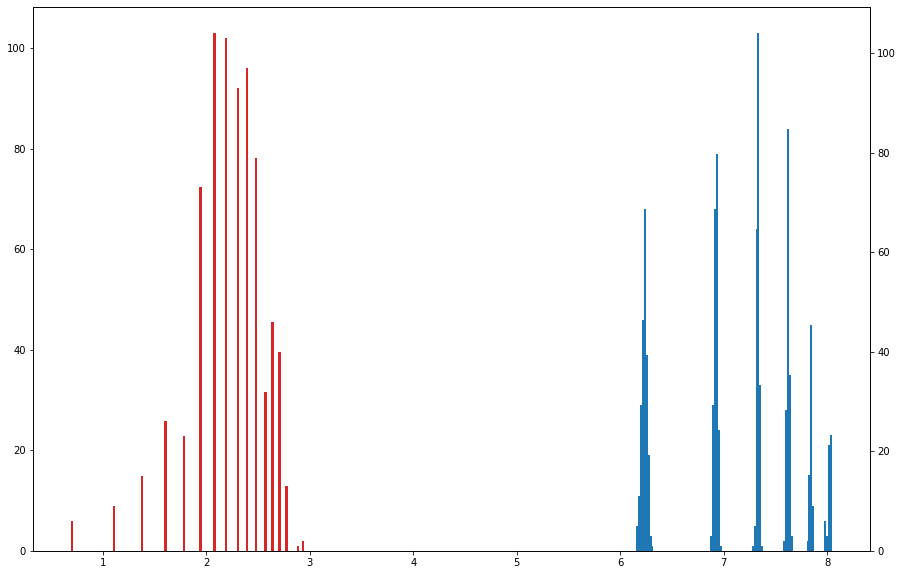

In [23]:
cc_freq = train_explore[train_explore.is_fraud == 0].cc_num.value_counts().reset_index()
cc_freq_fraud = train_explore.loc[train_explore.is_fraud == 1,:].cc_num.value_counts().reset_index()

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = ax.hist(np.log(cc_freq["cc_num"]), bins = 100)
hist = ax1.hist(np.log(cc_freq_fraud.cc_num), bins = 100, color = 'tab:red')

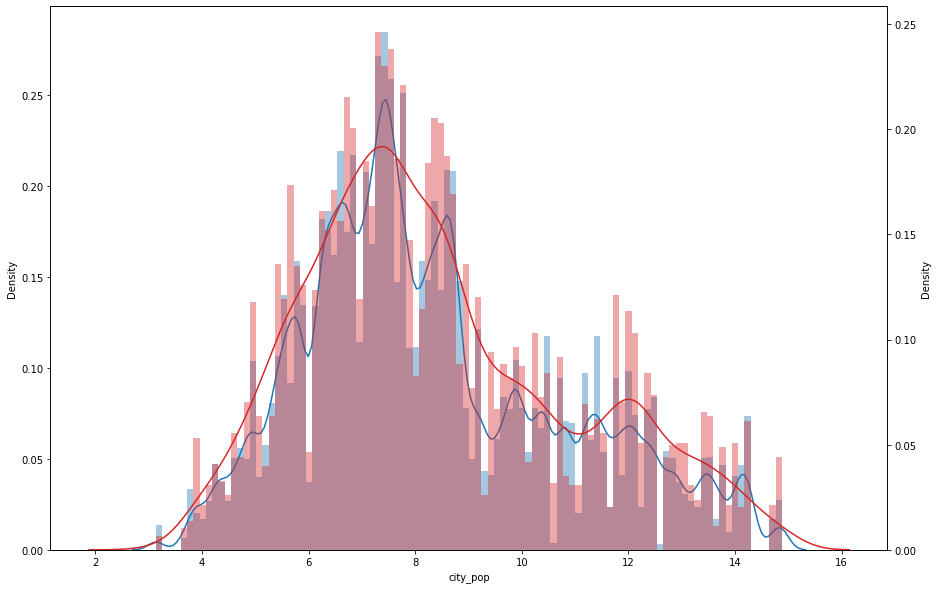

In [24]:
cc_freq = train_explore.city_pop
cc_freq_fraud = train_explore.loc[train_explore.is_fraud == 1,:].city_pop

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(cc_freq), bins = 100, ax = ax)
hist = sns.distplot(np.log(cc_freq_fraud), bins = 100, color = 'tab:red', ax= ax1)

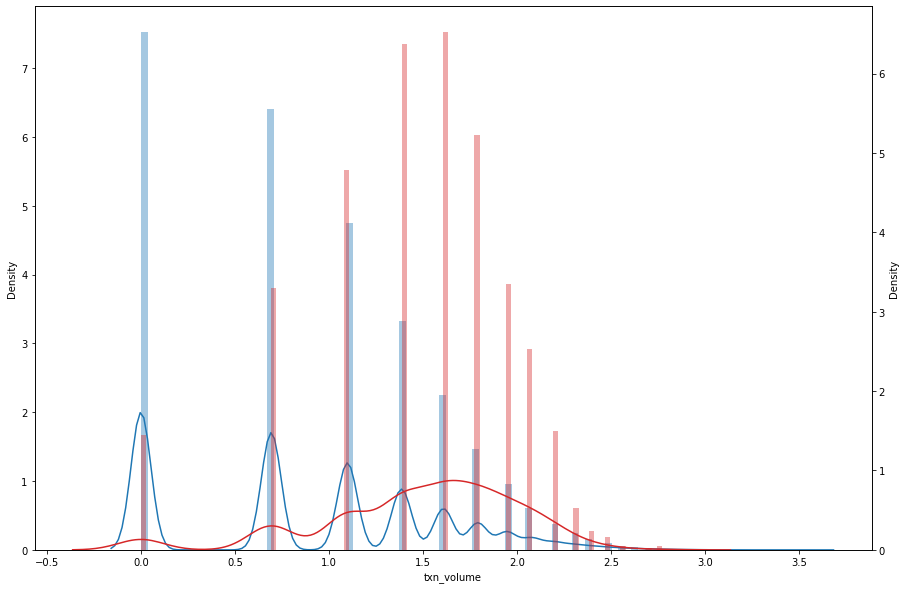

In [25]:
cc_day_freq = train_explore.loc[train_explore.is_fraud == 0,:].groupby(["cc_num","trans_date_trans_time_date"]).agg(txn_volume = ("amt","count"),txn_amount = ("amt","sum")).reset_index()
cc_day_freq_fraud = train_explore.loc[train_explore.is_fraud == 1,:].groupby(["cc_num","trans_date_trans_time_date"]).agg(txn_volume = ("amt","count"),txn_amount = ("amt","sum")).reset_index()


fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(cc_day_freq["txn_volume"]), bins = 100, ax = ax)
hist = sns.distplot(np.log(cc_day_freq_fraud["txn_volume"]), bins = 100, color = 'tab:red', ax= ax1)


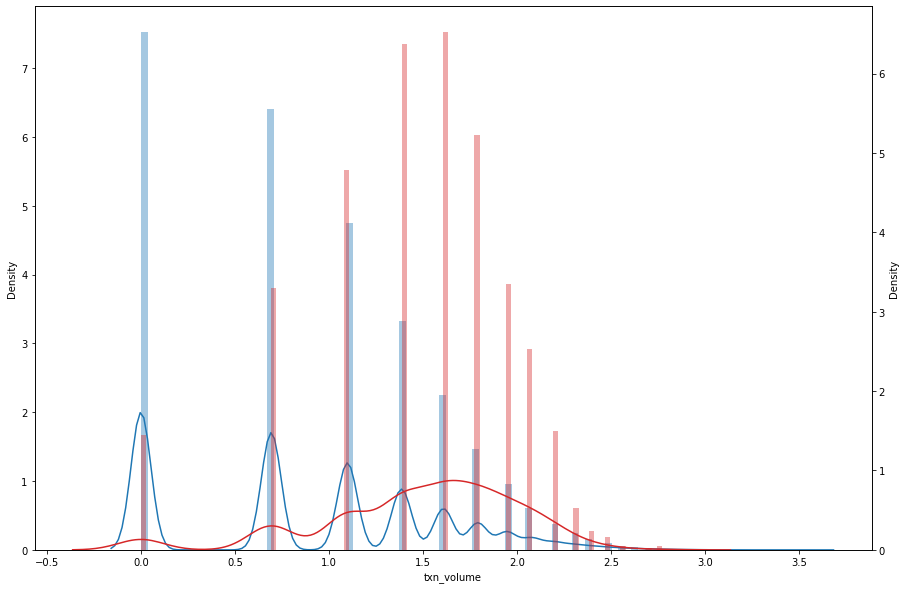

In [26]:
cc_day_freq = train_explore.loc[train_explore.is_fraud == 0,:].groupby(["cc_num","trans_date_trans_time_date"]).agg(txn_volume = ("amt","count"),txn_amount = ("amt","sum")).reset_index()
cc_day_freq_fraud = train_explore.loc[train_explore.is_fraud == 1,:].groupby(["cc_num","trans_date_trans_time_date"]).agg(txn_volume = ("amt","count"),txn_amount = ("amt","sum")).reset_index()


fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(cc_day_freq["txn_volume"]), bins = 100, ax = ax)
hist = sns.distplot(np.log(cc_day_freq_fraud["txn_volume"]), bins = 100, color = 'tab:red', ax= ax1)


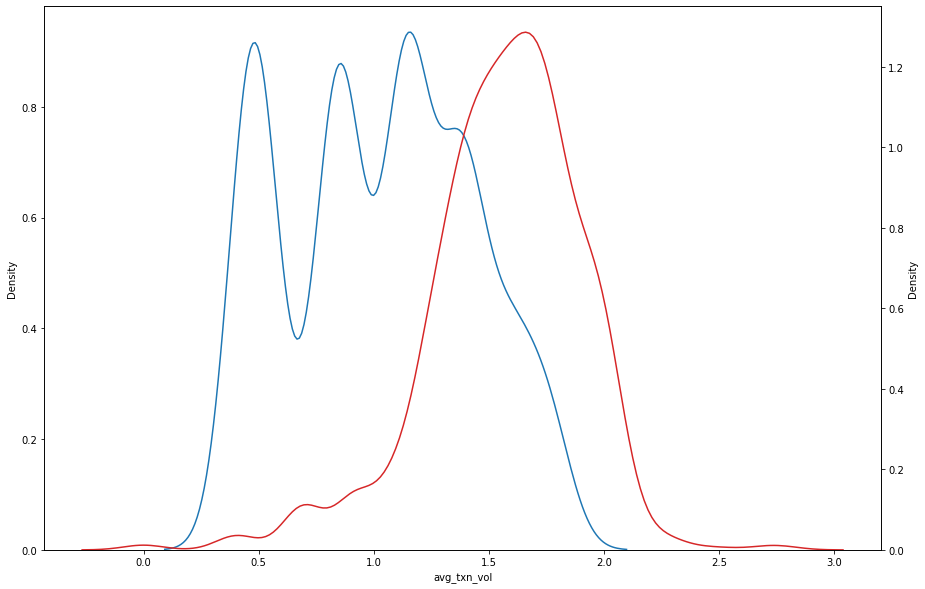

In [27]:
avg_txn_vol_nf = cc_day_freq.groupby(["cc_num"]).agg(avg_txn_vol = ("txn_volume","mean")).reset_index()
avg_txn_vol_f = cc_day_freq_fraud.groupby(["cc_num"]).agg(avg_txn_vol = ("txn_volume","mean")).reset_index()

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(avg_txn_vol_nf["avg_txn_vol"]),hist = False, bins = 100, ax = ax)
hist = sns.distplot(np.log(avg_txn_vol_f["avg_txn_vol"]),hist = False, bins = 100, color = 'tab:red', ax= ax1)

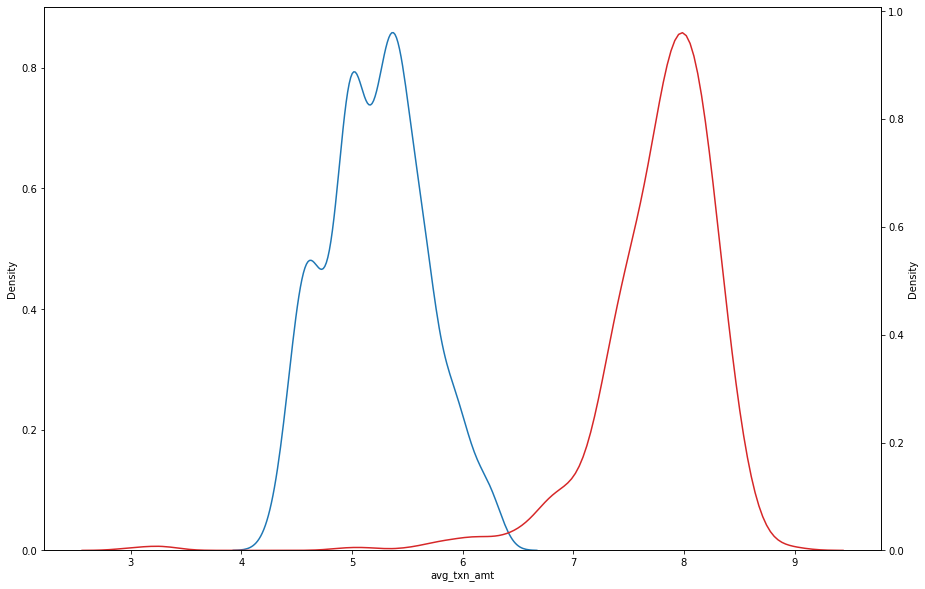

In [28]:
avg_txn_vol_nf = cc_day_freq.groupby(["cc_num"]).agg(avg_txn_amt = ("txn_amount","mean")).reset_index()
avg_txn_vol_f = cc_day_freq_fraud.groupby(["cc_num"]).agg(avg_txn_amt = ("txn_amount","mean")).reset_index()

fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(avg_txn_vol_nf["avg_txn_amt"]),hist = False, bins = 100, ax = ax)
hist = sns.distplot(np.log(avg_txn_vol_f["avg_txn_amt"]),hist = False, bins = 100, color = 'tab:red', ax= ax1)

In [29]:
avg_txn_amt_nf.loc[avg_txn_amt_nf.cc_num == 2703186189652095]

NameError: name 'avg_txn_amt_nf' is not defined

In [ ]:
cc_day_freq["daily_amount_per_txn"] = cc_day_freq.apply(lambda x: x["txn_amount"]/x["txn_volume"], axis = 1)
cc_day_freq_fraud["daily_amount_per_txn"] = cc_day_freq_fraud.apply(lambda x: x["txn_amount"]/x["txn_volume"], axis = 1)

avg_txn_amt_nf = cc_day_freq.groupby(["cc_num"]).agg( avg_txn_amount = ("txn_amount","mean"),avg_txn_vol = ("txn_volume","mean"), avg_amt_per_txn = ("daily_amount_per_txn","mean"),txn_vol_std = ("txn_volume", "std"), txn_amount_std = ("txn_amount",'std'), amount_per_txn_std = ("daily_amount_per_txn",'std') ).reset_index()
avg_txn_amt_f = cc_day_freq_fraud.groupby(["cc_num"]).agg(avg_txn_amount = ("txn_amount","mean"),avg_txn_vol = ("txn_volume","mean"),avg_amt_per_txn = ("daily_amount_per_txn","mean"),txn_vol_std = ("txn_volume", "std"), txn_amount_std = ("txn_amount",'std'), amount_per_txn_std = ("daily_amount_per_txn",'std') ).reset_index()


iter_cols = [i for i in avg_txn_amt_f.columns.tolist() if i not in  ["cc_num"]]

fig,ax = plt.subplots(3,2, figsize = (20,15))


for i, (a,c) in enumerate(zip(ax.flatten(),iter_cols)):
    
    
    ax1  = a.twinx()
    hist = sns.distplot(np.log(avg_txn_amt_nf[c]),hist = False, bins = 100, ax = a)
    hist = sns.distplot(np.log(avg_txn_amt_f[c]),hist = False, bins = 100, color = 'tab:red', ax= ax1)
    
    #title = a.set_title(c)
    

In [ ]:
sns.heatmap(tt, annot=True)

In [ ]:
tt = avg_txn_amt_nf.corr()

In [ ]:
corr_len = len(tt)

for i in range(corr_len):
    for l in range(corr_len):
        
        if i>l:
            tt.iloc[i,l] = None
        
        

In [38]:
fr

NameError: name 'fr' is not defined

In [54]:
dv = nfr.groupby(["cc_num"])["n_merchants"].mean().reset_index()
dv.loc[dv.cc_num == 2703186189652095]

cc_num  n_merchants
415  2703186189652095        476.0

In [53]:
train_explore.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'trans_date_trans_time_year',
       'trans_date_trans_time_month', 'trans_date_trans_time_week',
       'trans_date_trans_time_weekday', 'trans_date_trans_time_hour',
       'trans_date_trans_time_date', 'trans_date_trans_time_day', 'dob_year',
       'dob_month', 'dob_week', 'dob_weekday', 'dob_hour', 'dob_date',
       'dob_day', 'len_cc', 'purchase_type', 'week_category', 'len_cc_cutoff',
       'first_cc_num', 'log_amt', 'std_log_amt', 'norm_log_amt',
       'merchant_customer_distance'],
      dtype='object')

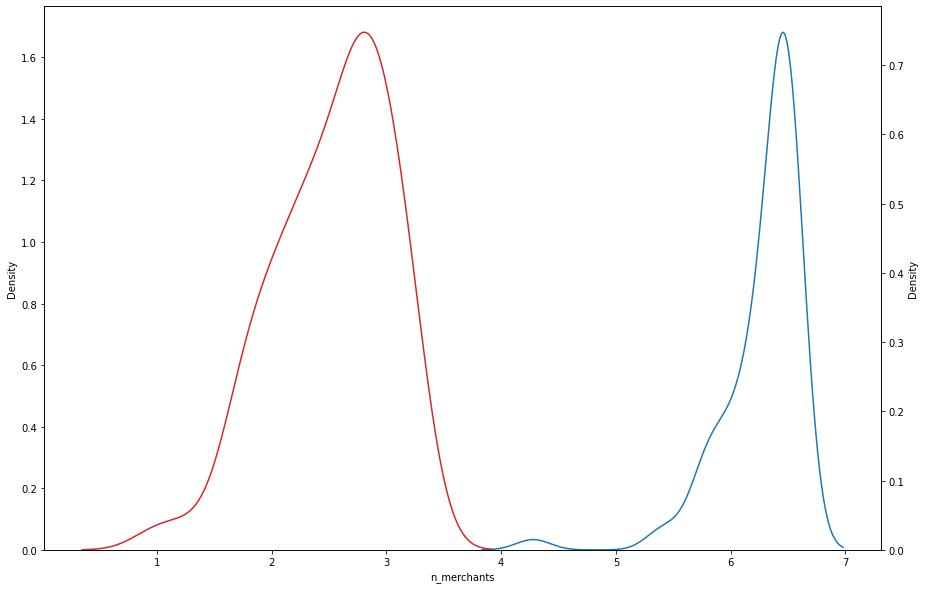

In [71]:
fr = train_explore.loc[train_explore.is_fraud == 1,:].groupby(["dob_year","trans_date_trans_time_weekday"]).agg(n_merchants = ("merchant","nunique")).reset_index()
nfr = train_explore.loc[train_explore.is_fraud == 0,:].groupby(["dob_year","trans_date_trans_time_weekday"]).agg(n_merchants = ("merchant","nunique")).reset_index()
dv = nfr.groupby(["dob_year"])["n_merchants"].mean().reset_index()
dvf = fr.groupby(["dob_year"])["n_merchants"].mean().reset_index()
fig,ax = plt.subplots(figsize = (15,10))

ax1  = ax.twinx()
hist = sns.distplot(np.log(dv["n_merchants"]),hist = False, bins = 100, ax = ax)
hist = sns.distplot(np.log(dvf["n_merchants"]),hist = False, bins = 100, color = 'tab:red', ax= ax1)


In [ ]:
#  pipleine stage
# binarization of : month,hour,state,

In [5]:
train.groupby()

Unnamed: 0 trans_date_trans_time               cc_num  \
0                 0   2019-01-01 00:00:18     2703186189652095   
1                 1   2019-01-01 00:00:44         630423337322   
2                 2   2019-01-01 00:00:51       38859492057661   
3                 3   2019-01-01 00:01:16     3534093764340240   
4                 4   2019-01-01 00:03:06      375534208663984   
...             ...                   ...                  ...   
1296670     1296670   2020-06-21 12:12:08       30263540414123   
1296671     1296671   2020-06-21 12:12:19     6011149206456997   
1296672     1296672   2020-06-21 12:12:32     3514865930894695   
1296673     1296673   2020-06-21 12:13:36     2720012583106919   
1296674     1296674   2020-06-21 12:13:37  4292902571056973207   

                                    merchant       category     amt  \
0                 fraud_Rippin, Kub and Mann       misc_net    4.97   
1            fraud_Heller, Gutmann and Zieme    grocery_pos  107.23   
2                       fraud_Lind-Buckridge  entertainment  220.11   
3         fraud_Kutch, Hermiston and Farrell  gas_transport   45.00   
4                        fraud_Keeling-Crist       misc_pos   41.96   
...                                      ...            ...     ...   
1296670                    fraud_Reichel Inc  entertainment   15.56   
1296671             fraud_Abernathy and Sons    food_dining   51.70   
1296672                 fraud_Stiedemann Ltd    food_dining  105.93   
1296673  fraud_Reinger, Weissnat and Strosin    food_dining   74.90   
1296674  fraud_Langosh, Wintheiser and Hyatt    food_dining    4.30   

               first       last gender                         street  \
0           Jennifer      Banks      F                 561 Perry Cove   
1          Stephanie       Gill      F   43039 Riley Greens Suite 393   
2             Edward    Sanchez      M       594 White Dale Suite 530   
3             Jeremy      White      M    9443 Cynthia Court Apt. 038   
4              Tyler     Garcia      M               408 Bradley Rest   
...              ...        ...    ...                            ...   
1296670         Erik  Patterson      M       162 Jessica Row Apt. 072   
1296671      Jeffrey      White      M  8617 Holmes Terrace Suite 651   
1296672  Christopher  Castaneda      M     1632 Cohen Drive Suite 639   
1296673       Joseph     Murray      M           42933 Ryan Underpass   
1296674      Jeffrey      Smith      M           135 Joseph Mountains   

                             city state    zip      lat      long  city_pop  \
0                  Moravian Falls    NC  28654  36.0788  -81.1781      3495   
1                          Orient    WA  99160  48.8878 -118.2105       149   
2                      Malad City    ID  83252  42.1808 -112.2620      4154   
3                         Boulder    MT  59632  46.2306 -112.1138      1939   
4                        Doe Hill    VA  24433  38.4207  -79.4629        99   
...                           ...   ...    ...      ...       ...       ...   
1296670                     Hatch    UT  84735  37.7175 -112.4777       258   
1296671                 Tuscarora    MD  21790  39.2667  -77.5101       100   
1296672  High Rolls Mountain Park    NM  88325  32.9396 -105.8189       899   
1296673                 Manderson    SD  57756  43.3526 -102.5411      1126   
1296674                      Sula    MT  59871  45.8433 -113.8748       218   

                                       job         dob  \
0                Psychologist, counselling  1988-03-09   
1        Special educational needs teacher  1978-06-21   
2              Nature conservation officer  1962-01-19   
3                          Patent attorney  1967-01-12   
4           Dance movement psychotherapist  1986-03-28   
...                                    ...         ...   
1296670                       Geoscientist  1961-11-24   
1296671   Production assistant, television  1979-12-11   
1296672        